# <u>Web Scraping</u>

## <u>Part \#2: Web Scraping and Web Crawling Using *Beautiful Soup*</u>

The World Wide Web is a potential treasure trove for a data scientist. But in order to access this data, we need to find it and extract it. In this notebook, you we learn about this process by web scraping and web crawling using a Python module called **Beautiful Soup**.

As an introduction to web scraping we will start by opening a page on Wikipedia, find all links to other Wikipedia pages on that page, then pick one of those links (randomly) to 'crawl' to another page.  We will continue this process and see where it leads us.

### <u>Importing Useful Modules</u>

First we will need to access modules to assist us - some of them are familiar, others are new.  Add some code comments to explain what these imports are used for.  You do not need to say exactly what we will use them for, just what their general purpose is.  You may want to look this up on the Internet.

In [1]:
from urllib.request import urlopen           # Used to open URL webpages
from bs4 import BeautifulSoup                # Used to read HTML of webpages 
import datetime                              # Used to create/use date and time objects
import random                                # Used to generate random numbers
import re                                    # Used to compare if Strings to expressions
import time                                  # Used to create time objects
from IPython.display import Image, display   # Used to display images in Python Notebook

### <u>Get Links from a Wikipedia Page</u>

Let's see how many links to other Wikipedia pages we can find on the Wikipedia page for Fremd High School.  First we will define a general function (method) to get links off of any Wikipedia page.  Remember that a big advantage of using functions (methods) is that we can reuse code and perform the same task over and over with different inputs but only one group of code statements. In short, this is an **abstraction that helps manage the complexity of our program**. 

In our case here we will be able to use this function to find page links for any Wikipedia page and not just FHS's page.  This will make it possible (and much more efficient) to perform our random 'crawl' through Wikipedia pages.    

In [2]:
def get_links(article_url):                                     # Create function to extract links from a given Wiki page
    html_page = urlopen("http://en.wikipedia.org"+article_url)  # Opens whatever page we are requesting
    bs_obj = BeautifulSoup(html_page, 'html.parser')            # Saves the html in a Beautiful Soup object
    
    # The next line finds specific HTML elements in the page we opened - notice the familiar tags and properties
    # find first div with if of bodycontent. Then it finds all links that have that regex
    # https://regex101.com helpful
    return bs_obj.find("div",{"id":"bodyContent"}).findAll("a",href=re.compile("^(/wiki/)((?!:).)*$"))

*Notice:* The return statement above uses a *regular expression*. The *re.compile()* method puts together an expression for the *findAll()* method to match to a certain *href*. The text below briefly explains what the various parts of the regular expression mean. 

What does *^(/wiki/)* look for?
    - The start of a string followed by the literal "/wiki/"
    
What does _((?!:).)*_ look for?
    - As many occurences as exist of anything that is not a ":" followed by a "."
    
What does  _$_ look for?
    - Anything from the current location to the end of the string

### <u>Counting the Links on Fremd's Wikipedia Page</u>

Next we will call our function, *get_links(articleUrl)*, by sending in the name of Wikipedia's Fremd High School page. The entire url is https://en.wikipedia.org/wiki/William_Fremd_High_School but we only need to send in the last part of the url since that is how we wrote our function.

In [3]:
links=get_links("/wiki/William_Fremd_High_School")  # Call to function created above
print(links[:5])

[<a href="/wiki/Palatine,_Illinois" title="Palatine, Illinois">Palatine</a>, <a href="/wiki/Illinois" title="Illinois">Illinois</a>, <a href="/wiki/Geographic_coordinate_system" title="Geographic coordinate system">Coordinates</a>, <a href="/wiki/Township_High_School_District_211" title="Township High School District 211">Township H.S. 211</a>, <a href="/wiki/Full-time_equivalent" title="Full-time equivalent">FTE</a>]


**<u>Question 4:</u>** How many links are on the Fremd High School Wikipedia page? You will need to write code in the cell below to find out.

*Hint: 'links' is a list, how can you find out how long it is?*
    
**<u>Your Answer:</u>** 277 links. I figured it out by using len since it is an array.

In [4]:
# Your code here
len(links)

277

**<u>Question 5:</u>**  What type of data is stored in links? You will need to write code in the cell below to find out.

**<u>Your Answer:</u>** A bs4.element.ResultSet.

In [5]:
# Your code below
type(links)

bs4.element.ResultSet

### <u>View the Links Stored in the Variable '*links*'</u>

Now let's look at all of these links:

In [6]:
print(links[:5])

[<a href="/wiki/Palatine,_Illinois" title="Palatine, Illinois">Palatine</a>, <a href="/wiki/Illinois" title="Illinois">Illinois</a>, <a href="/wiki/Geographic_coordinate_system" title="Geographic coordinate system">Coordinates</a>, <a href="/wiki/Township_High_School_District_211" title="Township High School District 211">Township H.S. 211</a>, <a href="/wiki/Full-time_equivalent" title="Full-time equivalent">FTE</a>]


### <u>Clean the List</u>

Now let's clean the page links up a bit. First we will use a list comprehension to create a list of only the href portion of each tag. Then we will look only at the page names by removing the text that appears at the beginning of each link.  

In [7]:
link_list=[link['href'] for link in links]   # Creates a list of href's for every link in the list
print(link_list[:5])
i=0
for link in link_list:                       # Iterate over the newly formed list
    link = link.replace('/wiki/','')         # Remove the repetitive text
    print(link)                              # Display the page names one per line
    i+=1
    if i == 10: break

['/wiki/Palatine,_Illinois', '/wiki/Illinois', '/wiki/Geographic_coordinate_system', '/wiki/Township_High_School_District_211', '/wiki/Full-time_equivalent']
Palatine,_Illinois
Illinois
Geographic_coordinate_system
Township_High_School_District_211
Full-time_equivalent
Forest_green
Gold_(color)
Fight_song
Mid-Suburban_League
High_school


# <u>Web Crawling</u>

Enough of just looking at the Fremd HS Wikipedia page. Now let's try to 'crawl' through some pages by randomly picking one of the links on the Fremd High School page and following it to see what page links appear on that page. Then we will pick a random link on the new page and continue this process until we have 20 links from 20 pages we've crawled through.

One of the reasons we picked Wikipedia pages to crawl through is that by doing web scraping there is the potential to flood a web server with requests. Wikipedia is used to receiving a lot of requests and can generally handle the volume. It is good practice, though, and considered common courtesy to put code into your web scraping program to pause in between requests.  The code is a simple "sleep" request. You will see this above with the link of code that reads *time.sleep(1)*.

In [8]:
import requests
from IPython.display import Image, display

# This next line "seeds" the random number generator at the current time (gives a somewhat random starting point)
# https://www.w3schools.com/python/ref_random_seed.asp
random.seed(int(datetime.datetime.now().strftime('%f')))
print(int(datetime.datetime.now().strftime('%f')))

links=get_links("/wiki/William_Fremd_High_School")                      # Extracts and creates a list of links from Fremd's webpage
for i in range(20):                                                     # Loop to run 20 times
    new_article = links[random.randint(0,len(links)-1)].attrs['href']   # Chooses random link from the list of links
    print(new_article)                                                  # Prints the random link
    links = get_links(new_article)                                      # Extract and creates a list of links from the new webpage
    #time.sleep(1)                                                       # 1-second break before another loop

147237
/wiki/Plum_Grove_Junior_High_School
/wiki/Steger_School_District_194
/wiki/Mannheim_School_District_83
/wiki/Burbank_School_District_111
/wiki/Palos_School_District_118
/wiki/Chicago_Ridge_School_District
/wiki/Rosemont_Elementary_School_District_78
/wiki/Indian_Springs_School_District_109
/wiki/Berkeley_School_District_87
/wiki/Park_Forest-Chicago_Heights_School_District_163
/wiki/Elementary_School_District_159
/wiki/Township_High_School_District_211
/wiki/Schaumburg_(Metra_station)
/wiki/Schaumburg,_Illinois
/wiki/South_Chicago_Heights,_Illinois
/wiki/Northbrook,_Illinois
/wiki/Inverness,_Illinois
/wiki/Kankakee_County,_Illinois
/wiki/Ford_County,_Illinois
/wiki/1920_United_States_census


### <u>Scraping Images</u>

We can scrape many kinds of data from webpages. Instead of just links, let's try scraping images. First, here's a function that looks for the URL of the main image for a Wikipedia article:

In [9]:
def get_image_url(article_url):
    html_page = urlopen("http://en.wikipedia.org"+article_url)                    # Opens whatever page we are requesting
    bs_obj = BeautifulSoup(html_page, 'html.parser')                              # Saves the html in a Beautiful Soup object
    try:
        image_url = bs_obj.find("meta",{"property":"og:image"}).attrs['content']  # Finds fist image on webpage, stores URL
        # <meta property="og:image" content="https://upload.wikimedia.org/wikipedia/en/1/13/William_Fremd_High_School_Logo.png"/>
        # finds meta with property og:image" and finds the content. We could go to the content link to get the image.
    except AttributeError:
        image_url = False                                                         # If no URL is available, store 'False' instead
    return image_url                                                              # Return image's URL

Test it out with the Fremd High School Wikipedia page:

In [10]:
get_image_url("/wiki/William_Fremd_High_School")  # Call to function created above

'https://upload.wikimedia.org/wikipedia/en/1/13/William_Fremd_High_School_Logo.png'

Now a function that takes a Wikipedia article URL as input and then performs the following steps:

* Get the URL of the main image on the page
* Saves the image as *output_image*
* Display the image in the notebook

In [11]:
# Is og_image the main picture?
def return_image(wiki_url,image_width):                         # Create function that accepts a Wiki topic and width desired
    
    if get_image_url(wiki_url) != False:                        # If there is an available URL        
        headers = {'User-Agent': 'Mozilla/5.0'}                     # Add a user-agent to our request
        # Does a user-agent tell that it is requesting the mozilla firefox site. If it is, is this how my phone gets a desktop site.
        img=get_image_url(wiki_url)                                 # Extract image's URL
        request = requests.get(img, headers = headers)              # Request the image
        if request.status_code == 200:                              # If the request resolves "Ok"
            url_to_file = request.content                           # Extract image data from URL
            extension = img.split('.')[-1]                          # Extract image's name
            name = "output/output_image." + extension               # Create new name for image file
            with open(name, 'wb') as image:                         # Create a new file to write information to
                image.write(url_to_file)                            # Write the images data to the file
            display(Image(filename=name,width=image_width))         # Open image in notebook
        else:                                                   # Otherwise, give the status code
            print("Error, Status Code:", request.status_code)

Let's test *return_image(wiki_url,image_width)* on the Fremd High School Wikipedia page and set an image width of 200 pixels:

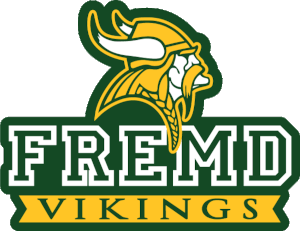

In [12]:
return_image("/wiki/William_Fremd_High_School", 200)  # Call to function created above

Go Vikings! Now Let's repeat our web crawl, but now with images (when available). 
* *Notes:*
    * Remember that this is a random crawl, so it is possible that you could encounter content on Wikipedia that is not school-appropriate. If this happens, simply rerun the cell below:
    * Some links may just display text, while others will also display an image (if present)

/wiki/Newsweek
/wiki/Arnold_Beichman


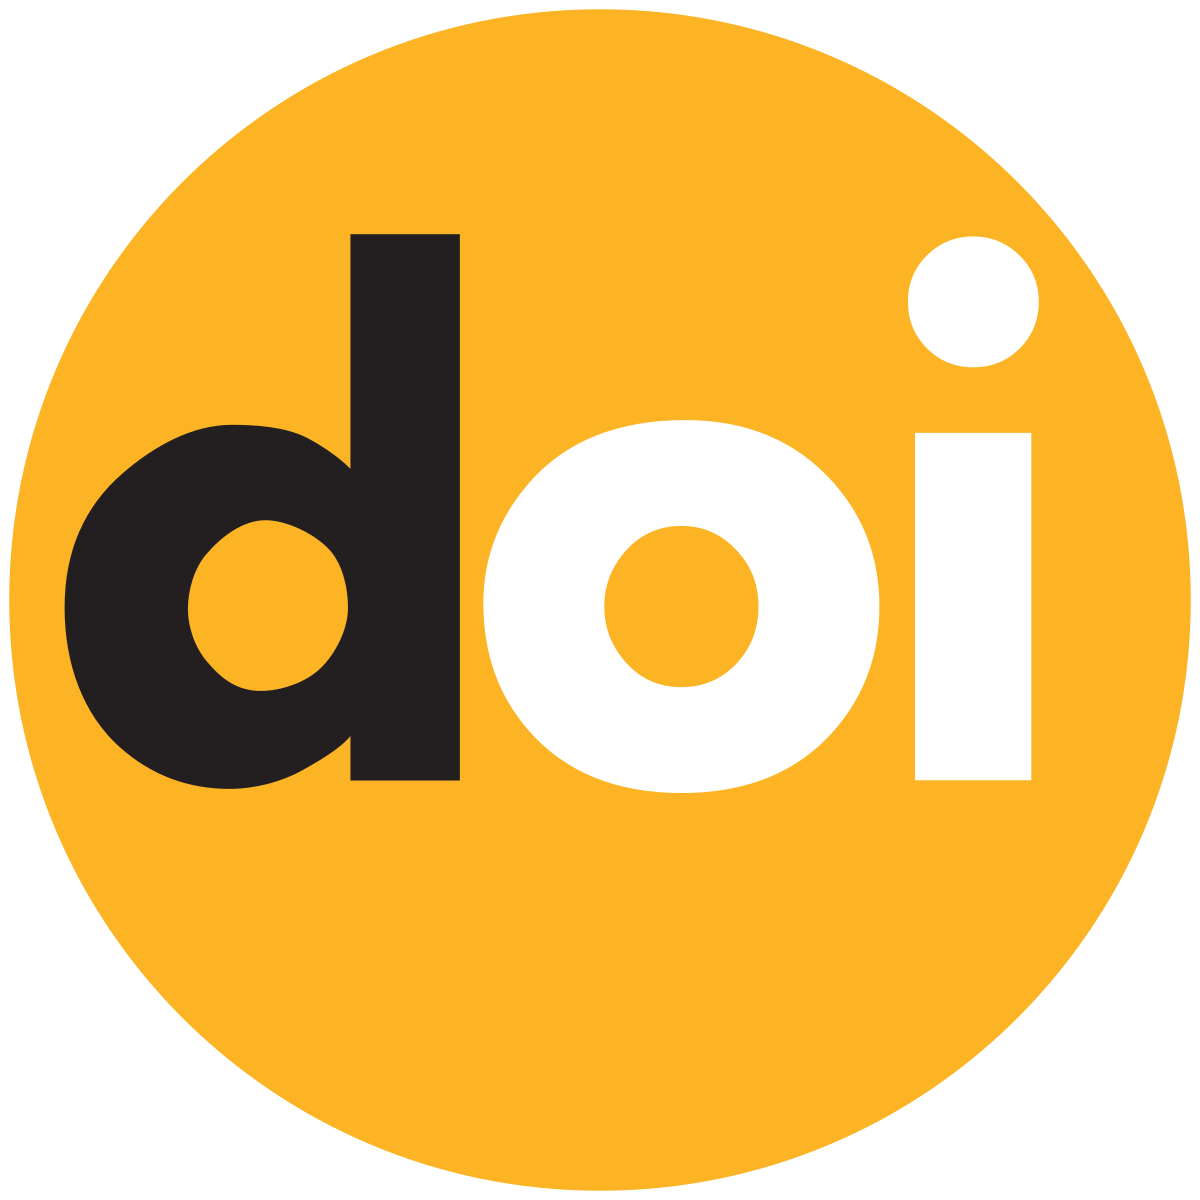

/wiki/Doi_(identifier)
/wiki/ISO_15706-2
/wiki/COLLADA


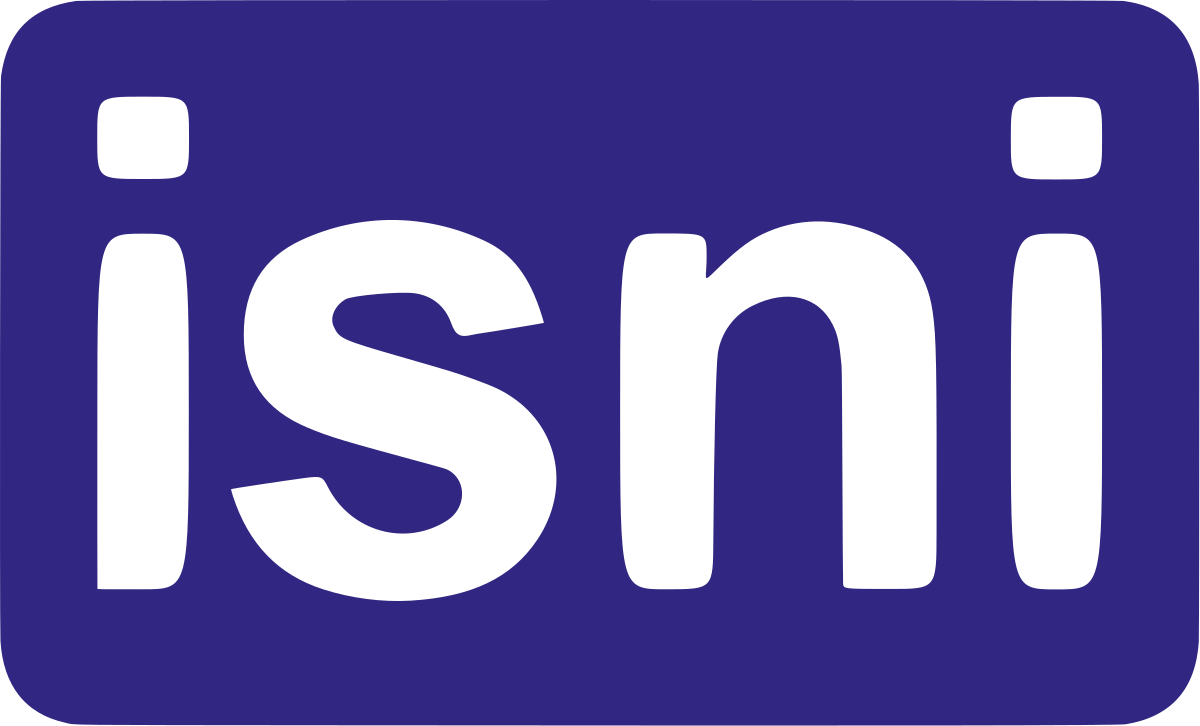

/wiki/International_Standard_Name_Identifier


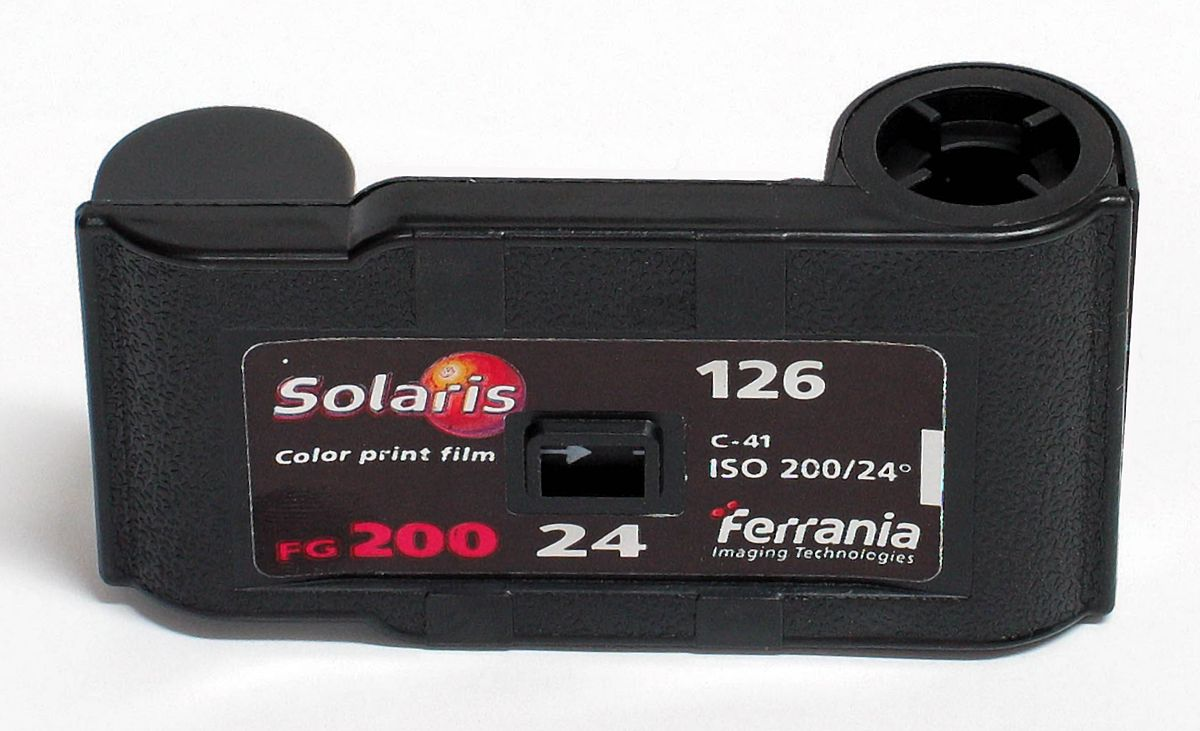

/wiki/126_film
/wiki/ISO_31-13
/wiki/Graphical_Kernel_System
/wiki/ISO/IEC_8859-15
/wiki/Mac_OS_Armenian
/wiki/Binary_Ordered_Compression_for_Unicode


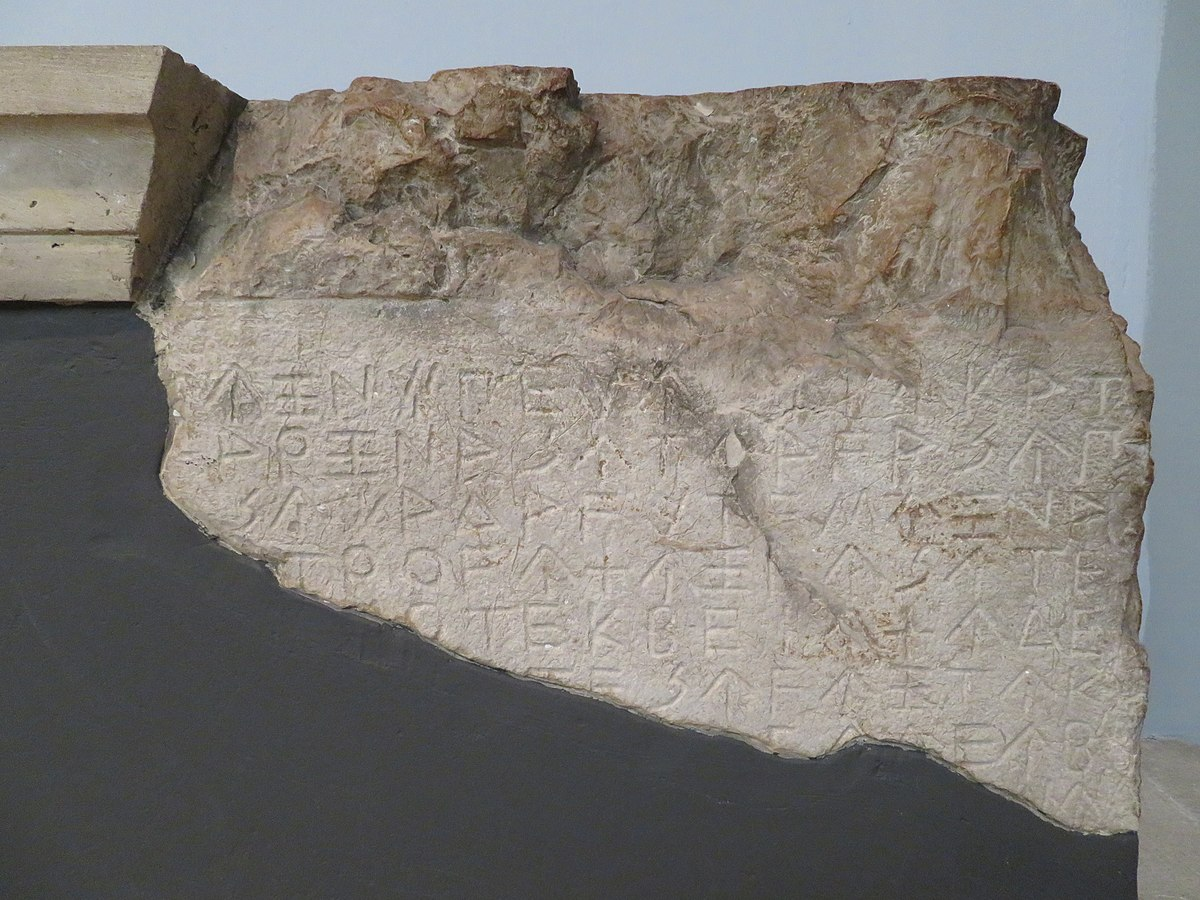

/wiki/Lycian_alphabet


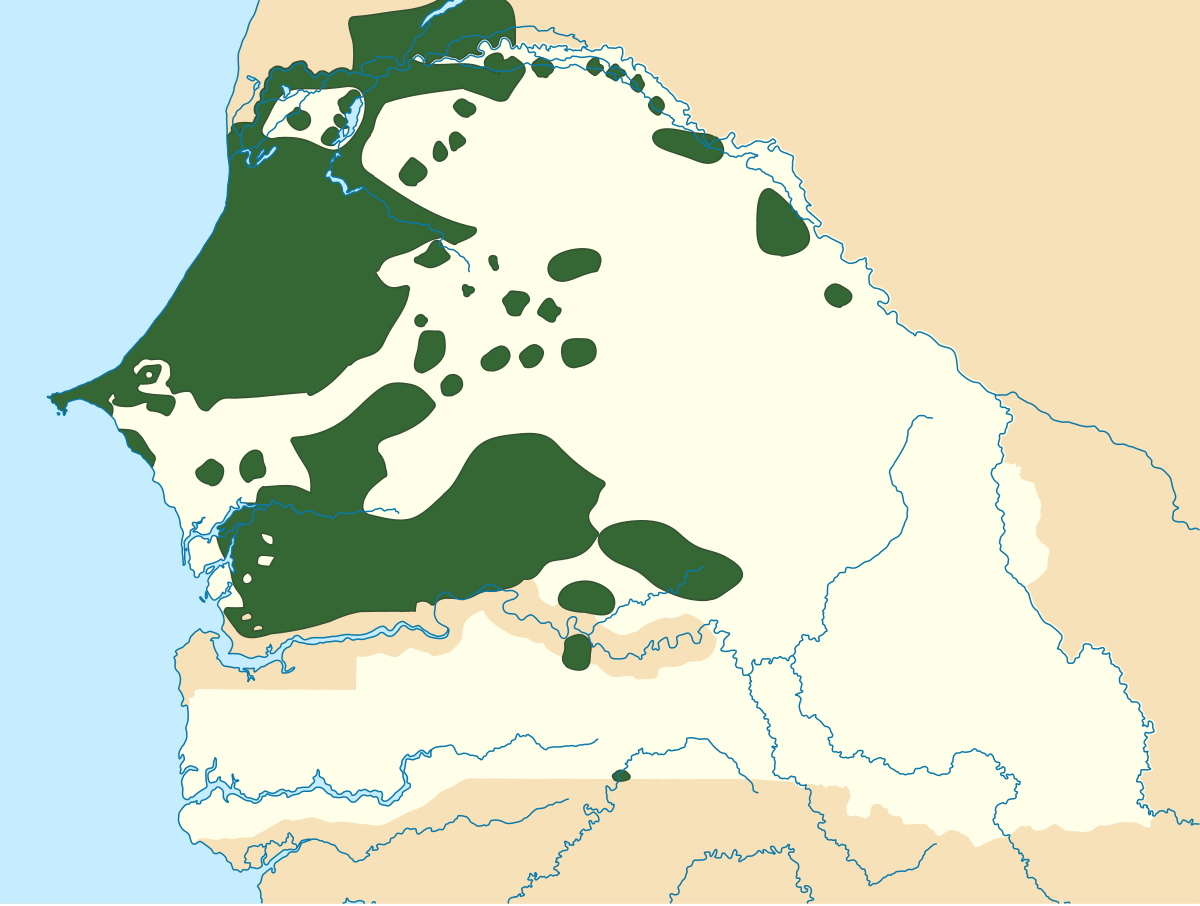

/wiki/Wolof_language#Orthography_and_pronunciation


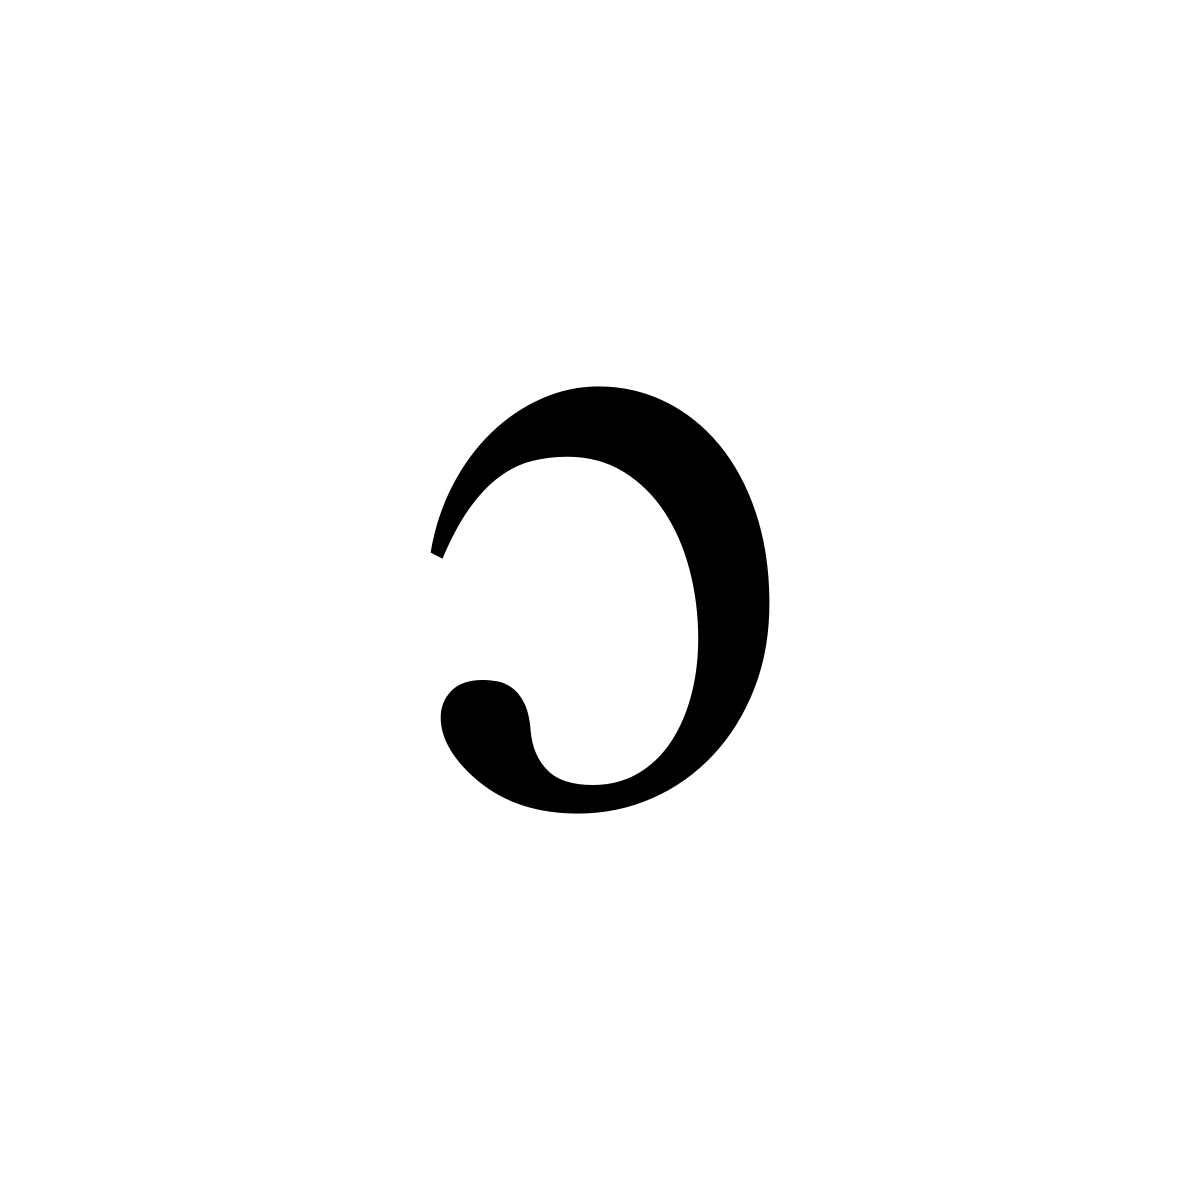

/wiki/Open-mid_back_rounded_vowel
/wiki/Standard_German


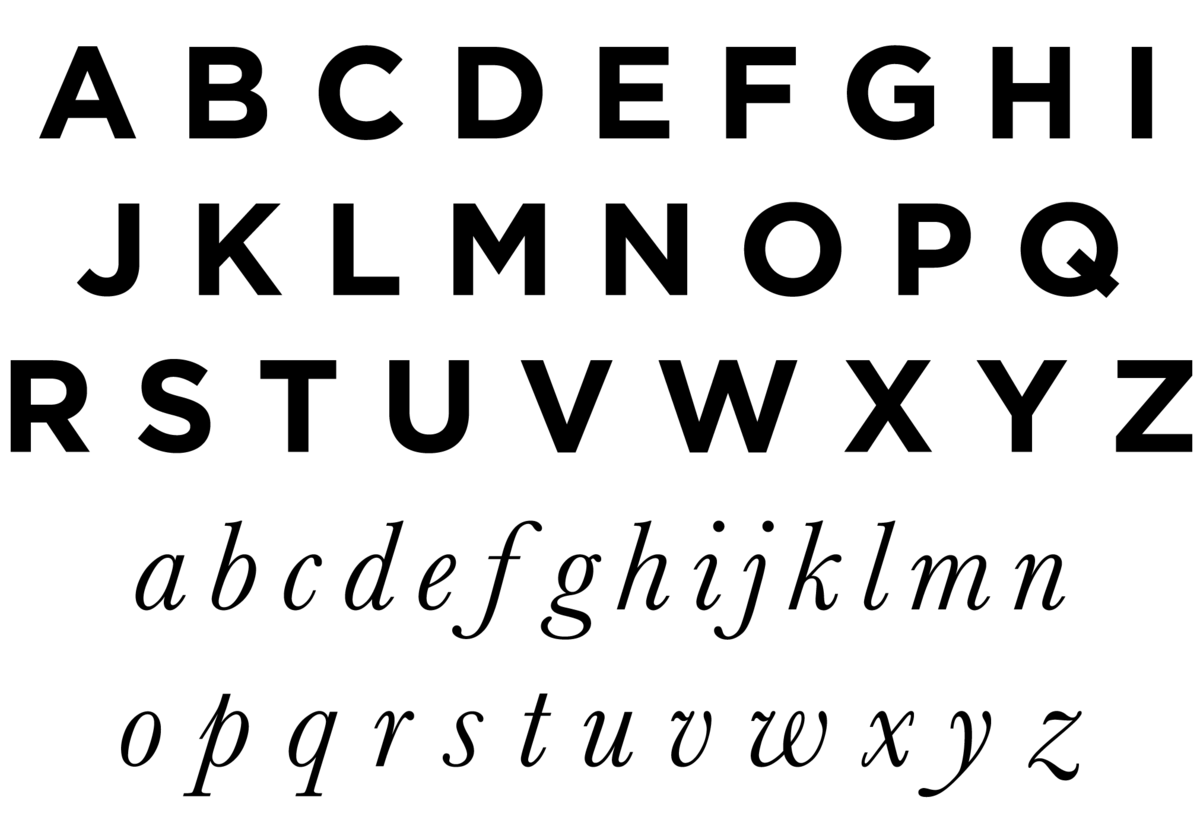

/wiki/Latin_alphabet


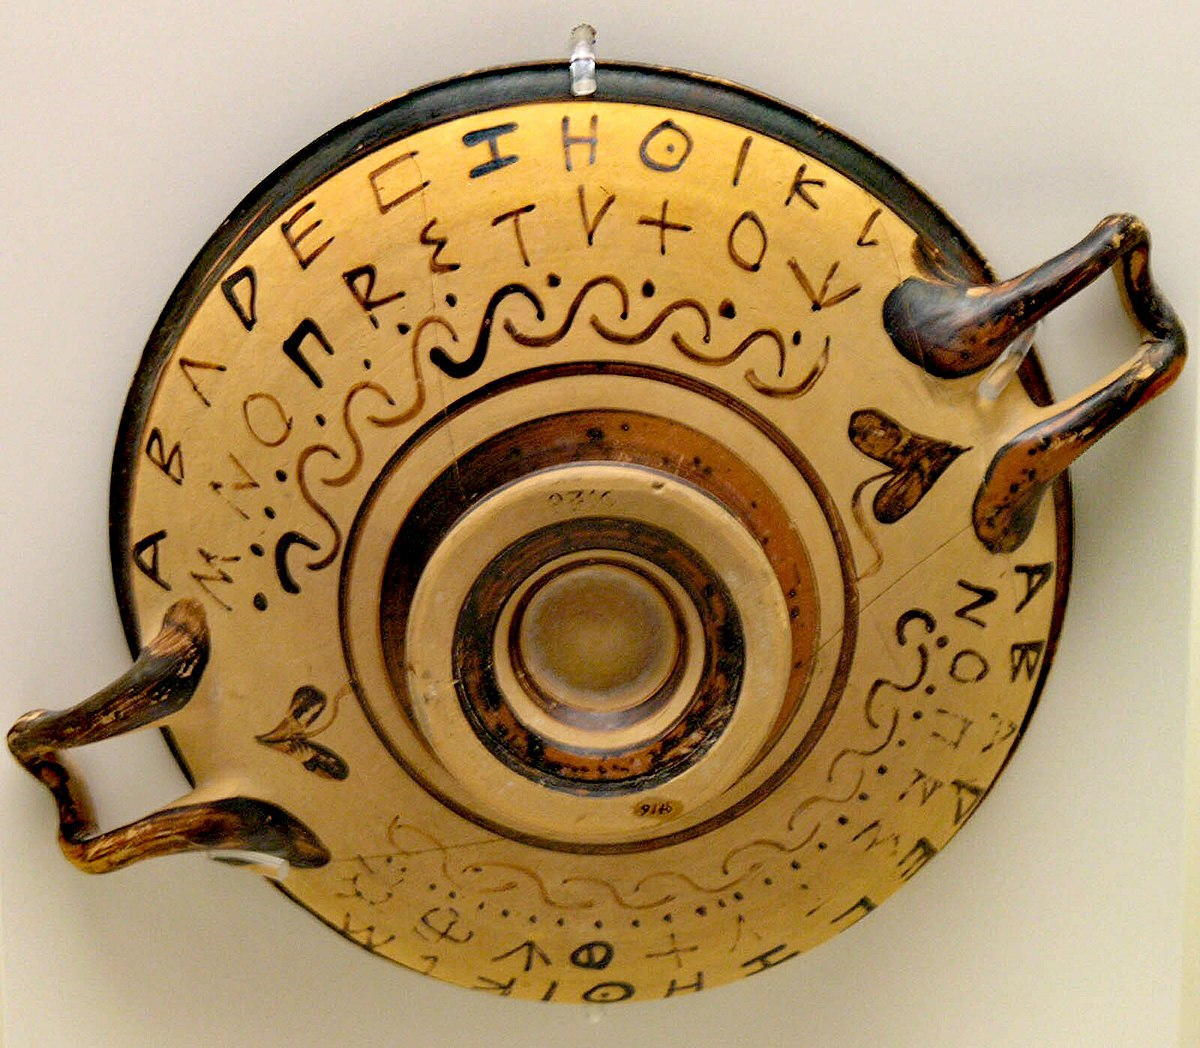

/wiki/Letter_(alphabet)
/wiki/%EA%AF%A1


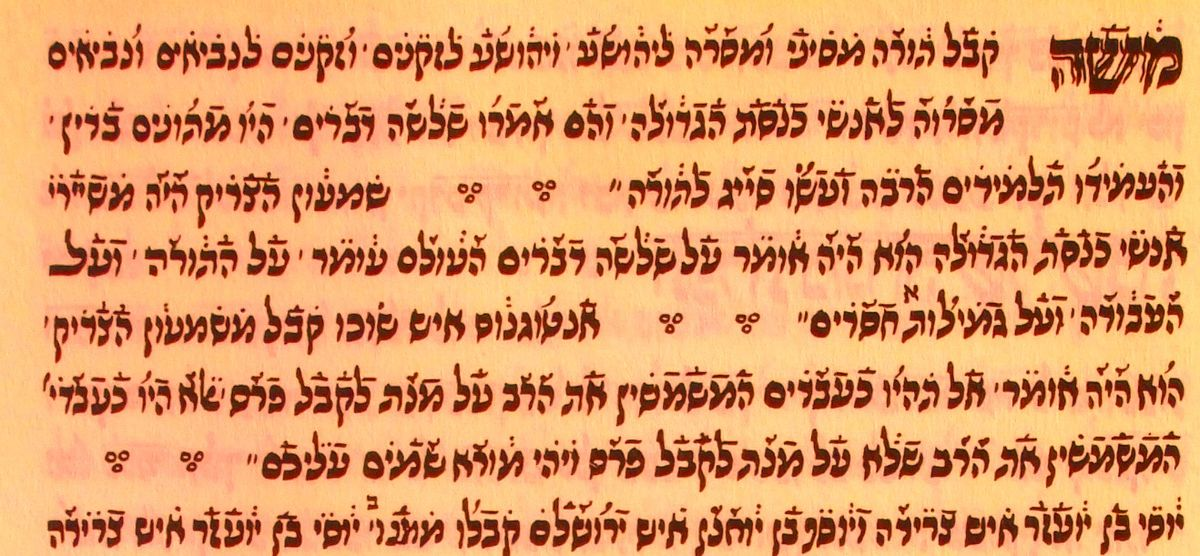

/wiki/Ktav_Ashuri


In [13]:
# This next line "seeds" the random number generator at the current time (gives a somewhat random starting point)
random.seed(int(datetime.datetime.now().strftime('%f')))  

links=get_links("/wiki/William_Fremd_High_School")                      # Extracts and creates a list of links from Fremd's webpage
for i in range(20):                                                     # Loop to run 20 times
    new_article = links[random.randint(0,len(links)-1)].attrs['href']   # Chooses random link from the list of links
    return_image(new_article,100)                                       # Call function created above, displays first image from link
    print(new_article)                                                  # Prints the random link
    links = get_links(new_article)                                      # Extracts and creates a list of links from the new webpage
    #time.sleep(1)                                                       # 1-second break before another loop

### <u>Experiment With a New Wikipedia Page</u>

Now pick a Wikipedia page on a school-appropriate topic you are interested in and then try the following: 

#### <u>Scrape URL links from this page</u> 
   * Create a 'cleaned up' list of all the links from this wikipage

In [14]:
# Your code here
webpage = '/wiki/Reddit'
links=get_links(webpage)  # Call to function created above
print(links[:5])

[<a href="/wiki/Redditt" title="Redditt">Redditt</a>, <a class="mw-redirect" href="/wiki/Types_of_business_entity" title="Types of business entity">Type of business</a>, <a class="mw-redirect" href="/wiki/Social_news" title="Social news">Social news</a>, <a href="/wiki/English_language" title="English language">English</a>, <a class="mw-redirect" href="/wiki/Multilingual" title="Multilingual">Multilingual</a>]


In [15]:
#import random
#array = [0,1,2,3,4,5]
#cool = [random.randint(0,10) for i in array]
#print(cool)

In [16]:
link_list=[link['href'] for link in links]
i = 0
for link in link_list:
    link = link.replace('/wiki/','')
    print(link.replace('/wiki/',''))
    i += 1
    if i == 10: break
#cleaned_link = [link.replace('/wiki/','') for link in links]
#print(cleaned_link)

Redditt
Types_of_business_entity
Social_news
English_language
Multilingual
San_Francisco,_California
Advance_Publications
Organizational_founder
Steve_Huffman
Aaron_Swartz


#### <u>Scrape an image from this page</u>
* Find the main picture from this Wikipedia page and display it in this notebook

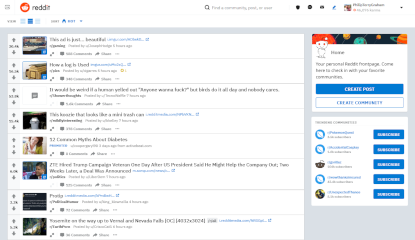

In [17]:
return_image(webpage, 200)  # Call to function created above

In [18]:
def better_get_image_url(article_url):
    html_page = urlopen("http://en.wikipedia.org"+article_url)                    # Opens whatever page we are requesting
    bs_obj = BeautifulSoup(html_page, 'html.parser')                              # Saves the html in a Beautiful Soup object
    try:
        image_url = bs_obj.find("td",{"class":"infobox-image"}).find('a').find('img').attrs['src']
    except AttributeError:
        image_url = False                                                         # If no URL is available, store 'False' instead
    return image_url                                                              # Return image's URL

In [19]:
# Is og_image the main picture?
def better_return_image(wiki_url,image_width):                         # Create function that accepts a Wiki topic and width desired
    
    if better_get_image_url(wiki_url) != False:                        # If there is an available URL        
        headers = {'User-Agent': 'Mozilla/5.0'}                     # Add a user-agent to our request
        # Does a user-agent tell that it is requesting the mozilla firefox site. If it is, is this how my phone gets a desktop site.
        img = better_get_image_url(wiki_url)                             # Extract image's URL
        img = 'http:' + img
        request = requests.get(img, headers = headers)              # Request the image
        if request.status_code == 200:                              # If the request resolves "Ok"
            url_to_file = request.content                           # Extract image data from URL
            extension = img.split('.')[-1]                          # Extract image's name
            name = "output/output_image." + extension               # Create new name for image file
            with open(name, 'wb') as image:                         # Create a new file to write information to
                image.write(url_to_file)                            # Write the images data to the file
            display(Image(filename=name,width=image_width))         # Open image in notebook
        else:                                                   # Otherwise, give the status code
            print("Error, Status Code:", request.status_code)

In [20]:
better_get_image_url(webpage)

'//upload.wikimedia.org/wikipedia/en/thumb/5/58/Reddit_logo_new.svg/220px-Reddit_logo_new.svg.png'

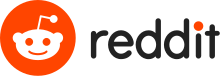

In [21]:
better_return_image(webpage, 200)

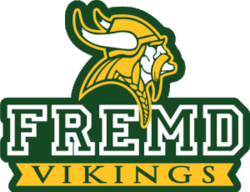

In [22]:
better_return_image('/wiki/William_Fremd_High_School', 200)

#### <u>Start your own web crawl</u>
* Run code to crawl through pages based on links that are found on the wiki pages
* Start with your chosen wiki page, then run a loop 20 times to open a random link from each new webpage
* Display all links and images found

*Hints:*
   * Only one change is needed from the code we used above to crawl from FHS's wiki! 
   * Change 'links' to be your list of links you created just above

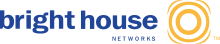

/wiki/Bright_House_Networks


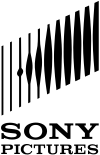

/wiki/Sony_Pictures
/wiki/Tony_Vinciquerra


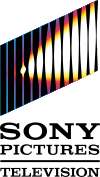

/wiki/Sony_Pictures_Television


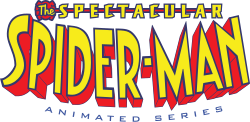

/wiki/The_Spectacular_Spider-Man_(TV_series)
/wiki/Action_(genre)
/wiki/Epitasis
/wiki/Fictional_city


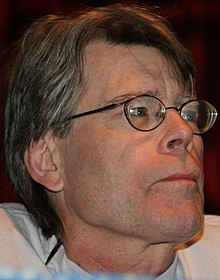

/wiki/Stephen_King


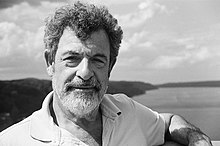

/wiki/Dolores_Claiborne_(opera)


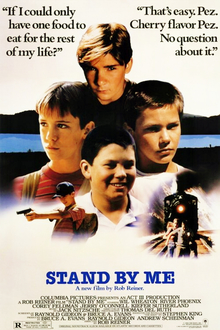

/wiki/Stand_by_Me_(film)
/wiki/Andrew_Scheinman


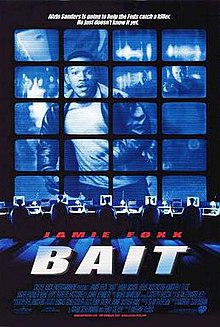

/wiki/Bait_(2000_film)


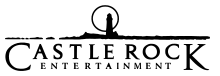

/wiki/Castle_Rock_Entertainment


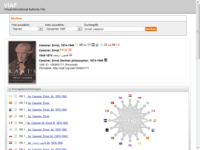

/wiki/VIAF_(identifier)


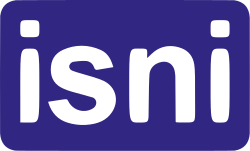

/wiki/International_Standard_Name_Identifier


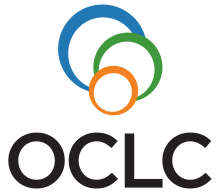

/wiki/Online_Computer_Library_Center
/wiki/Society_of_American_Archivists


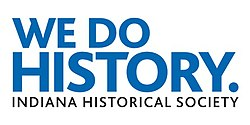

/wiki/Indiana_Historical_Society


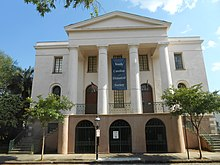

/wiki/South_Carolina_Historical_Society


['/wiki/Bright_House_Networks',
 '/wiki/Sony_Pictures',
 '/wiki/Tony_Vinciquerra',
 '/wiki/Sony_Pictures_Television',
 '/wiki/The_Spectacular_Spider-Man_(TV_series)',
 '/wiki/Action_(genre)',
 '/wiki/Epitasis',
 '/wiki/Fictional_city',
 '/wiki/Stephen_King',
 '/wiki/Dolores_Claiborne_(opera)',
 '/wiki/Stand_by_Me_(film)',
 '/wiki/Andrew_Scheinman',
 '/wiki/Bait_(2000_film)',
 '/wiki/Castle_Rock_Entertainment',
 '/wiki/VIAF_(identifier)',
 '/wiki/International_Standard_Name_Identifier',
 '/wiki/Online_Computer_Library_Center',
 '/wiki/Society_of_American_Archivists',
 '/wiki/Indiana_Historical_Society',
 '/wiki/South_Carolina_Historical_Society']

In [23]:
# This next line "seeds" the random number generator at the current time (gives a somewhat random starting point)
random.seed(int(datetime.datetime.now().strftime('%f')))  

links=get_links(webpage)                      # Extracts and creates a list of links from Fremd's webpage
links_from_crawl = []
for i in range(20):                                                     # Loop to run 20 times
    new_article = links[random.randint(0,len(links)-1)].attrs['href']   # Chooses random link from the list of links
    better_return_image(new_article,100)                                       # Call function created above, displays first image from link
    print(new_article)                                                  # Prints the random link
    links_from_crawl.append(new_article)
    links = get_links(new_article)                                      # Extracts and creates a list of links from the new webpage
    #time.sleep(1)                                                       # 1-second break before another loop
links_from_crawl

/wiki/Bright_House_Networks


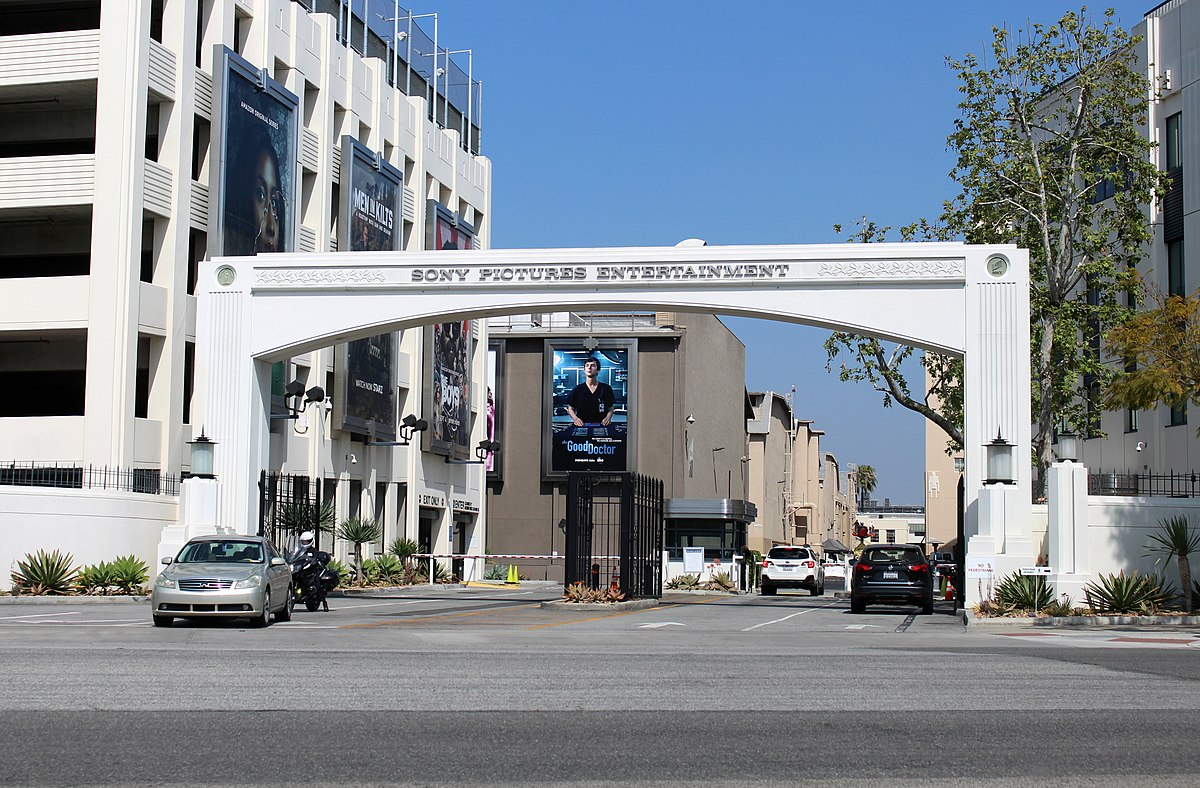

/wiki/Sony_Pictures
/wiki/Tony_Vinciquerra
/wiki/Sony_Pictures_Television


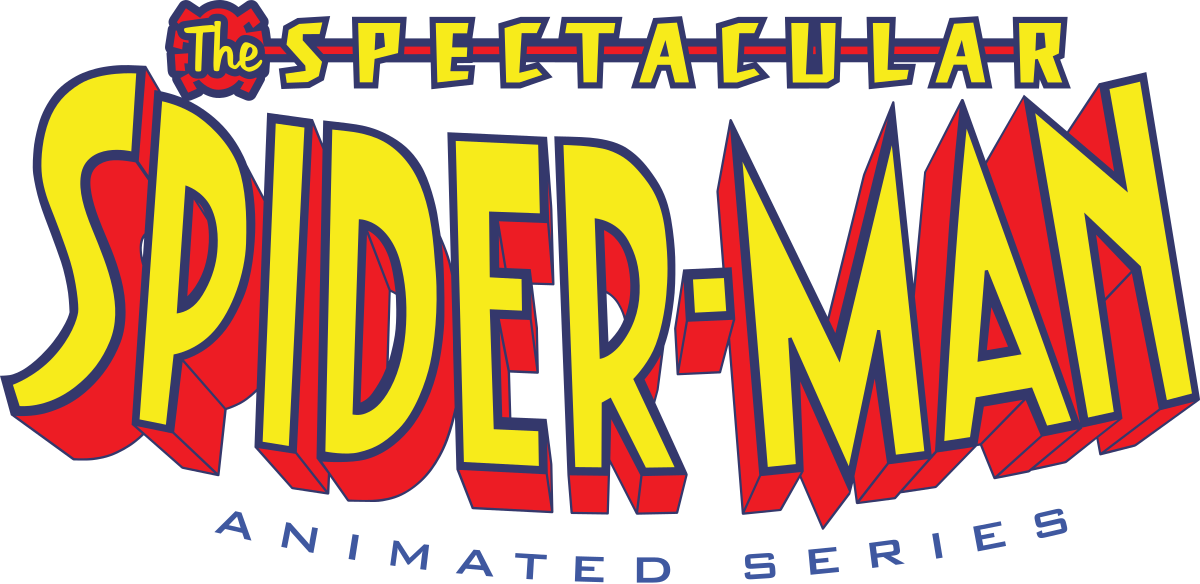

/wiki/The_Spectacular_Spider-Man_(TV_series)
/wiki/Action_(genre)
/wiki/Epitasis


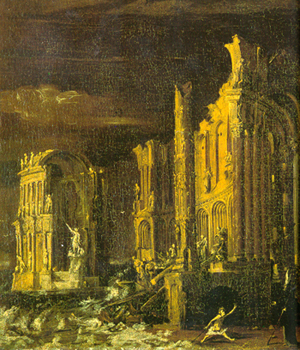

/wiki/Fictional_city


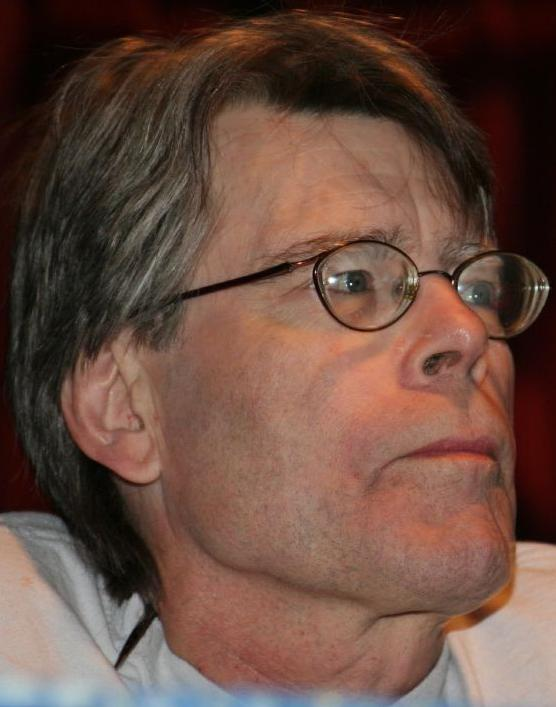

/wiki/Stephen_King


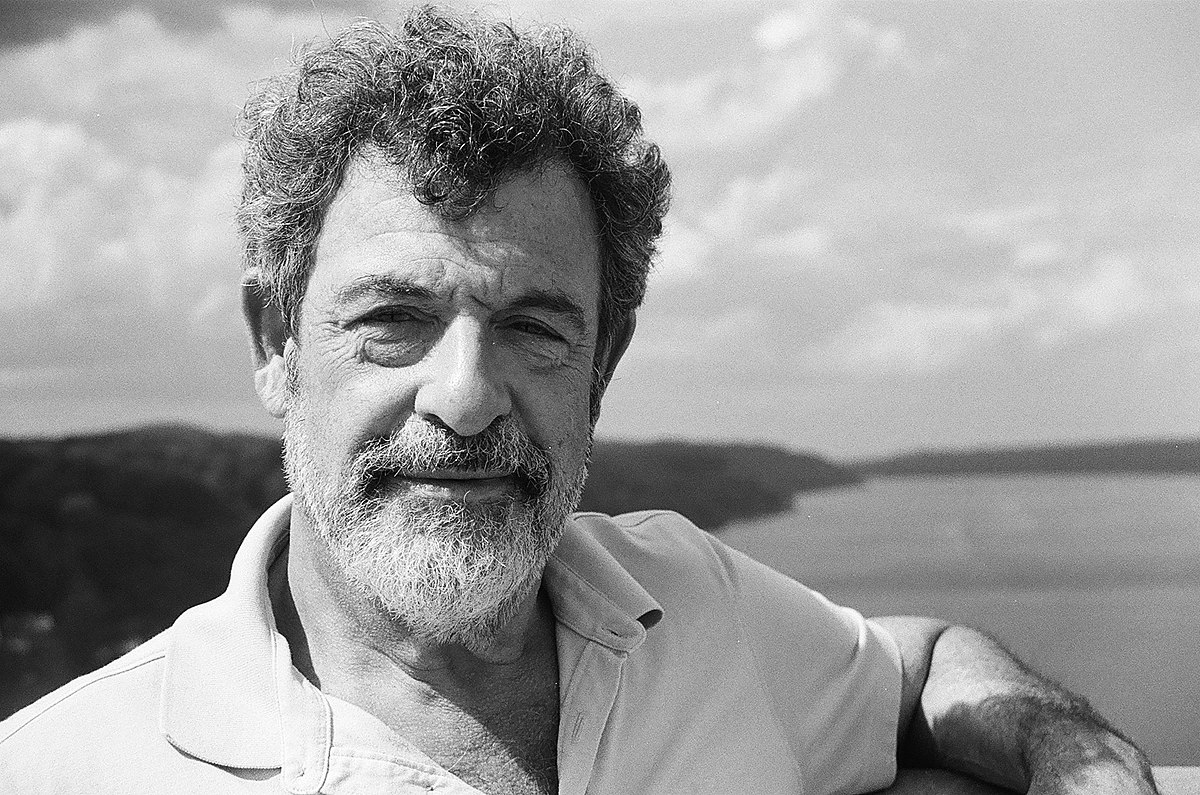

/wiki/Dolores_Claiborne_(opera)


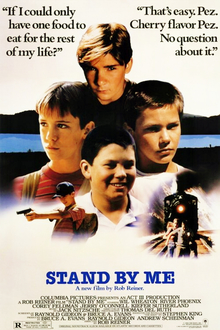

/wiki/Stand_by_Me_(film)
/wiki/Andrew_Scheinman


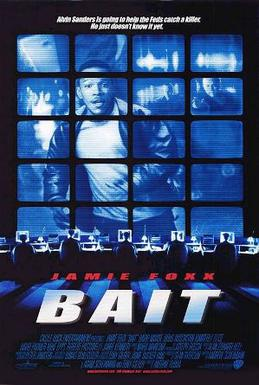

/wiki/Bait_(2000_film)


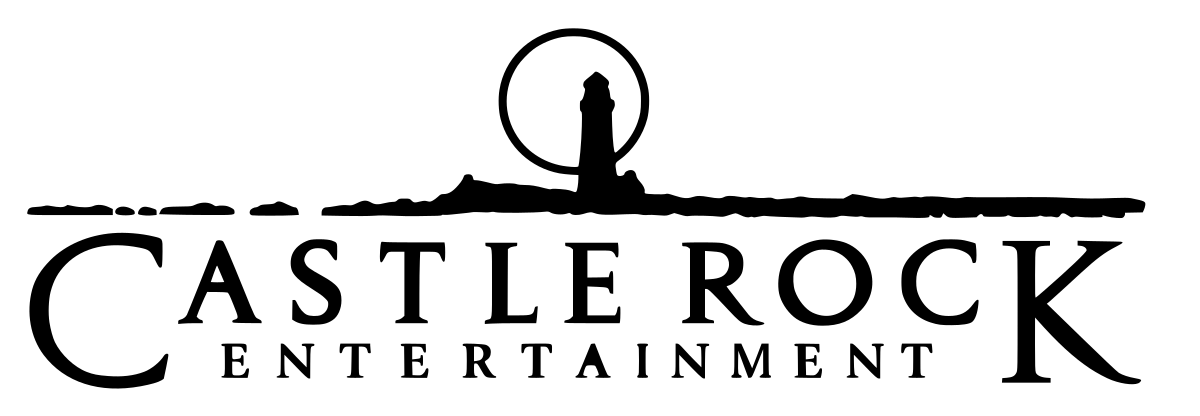

/wiki/Castle_Rock_Entertainment


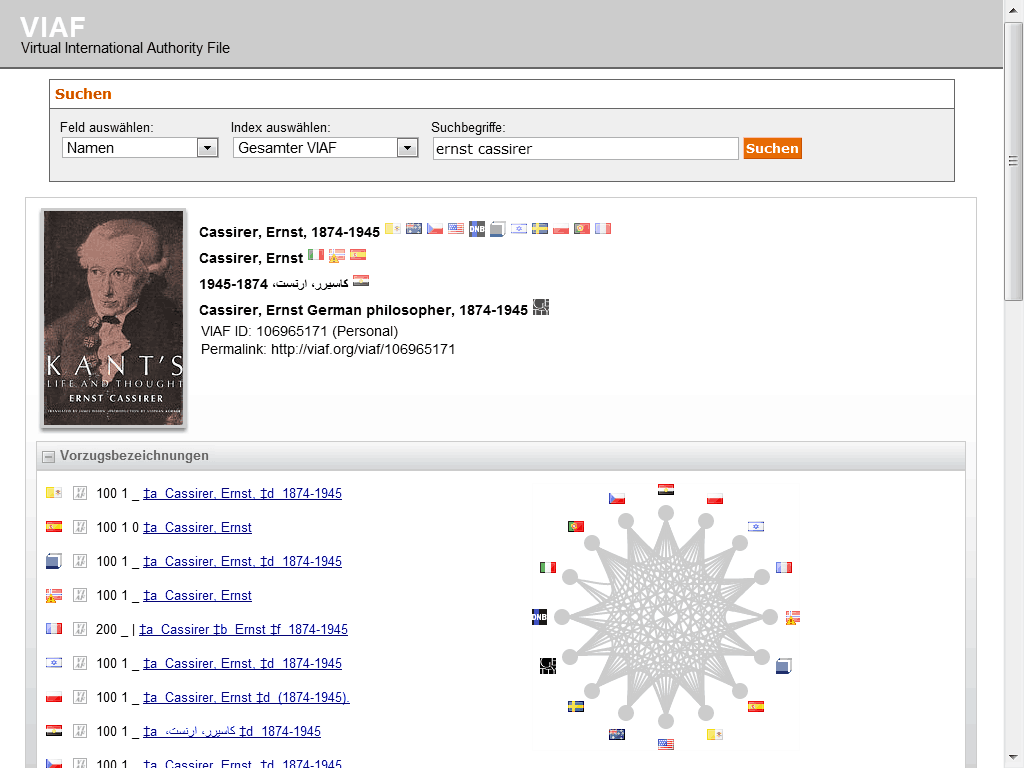

/wiki/VIAF_(identifier)


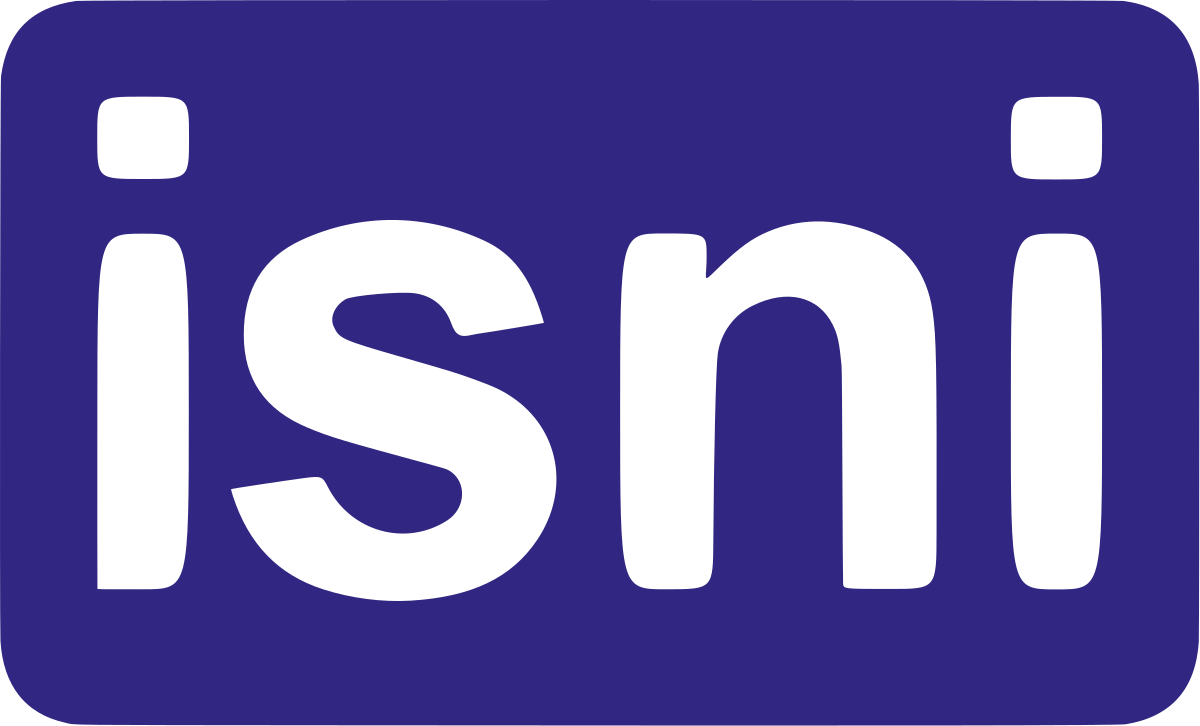

/wiki/International_Standard_Name_Identifier


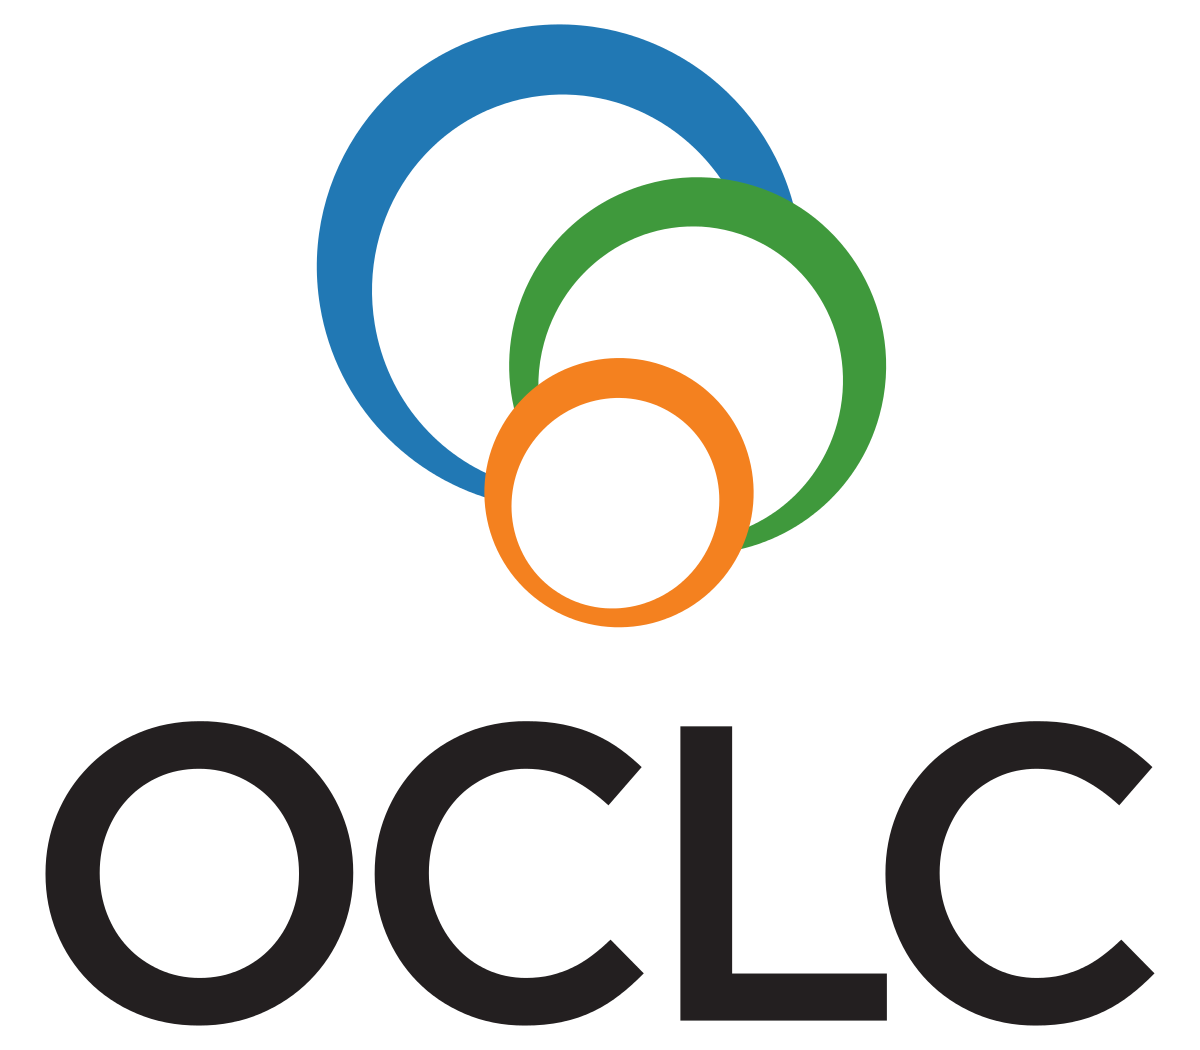

/wiki/Online_Computer_Library_Center
/wiki/Society_of_American_Archivists


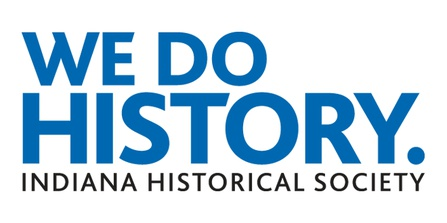

/wiki/Indiana_Historical_Society


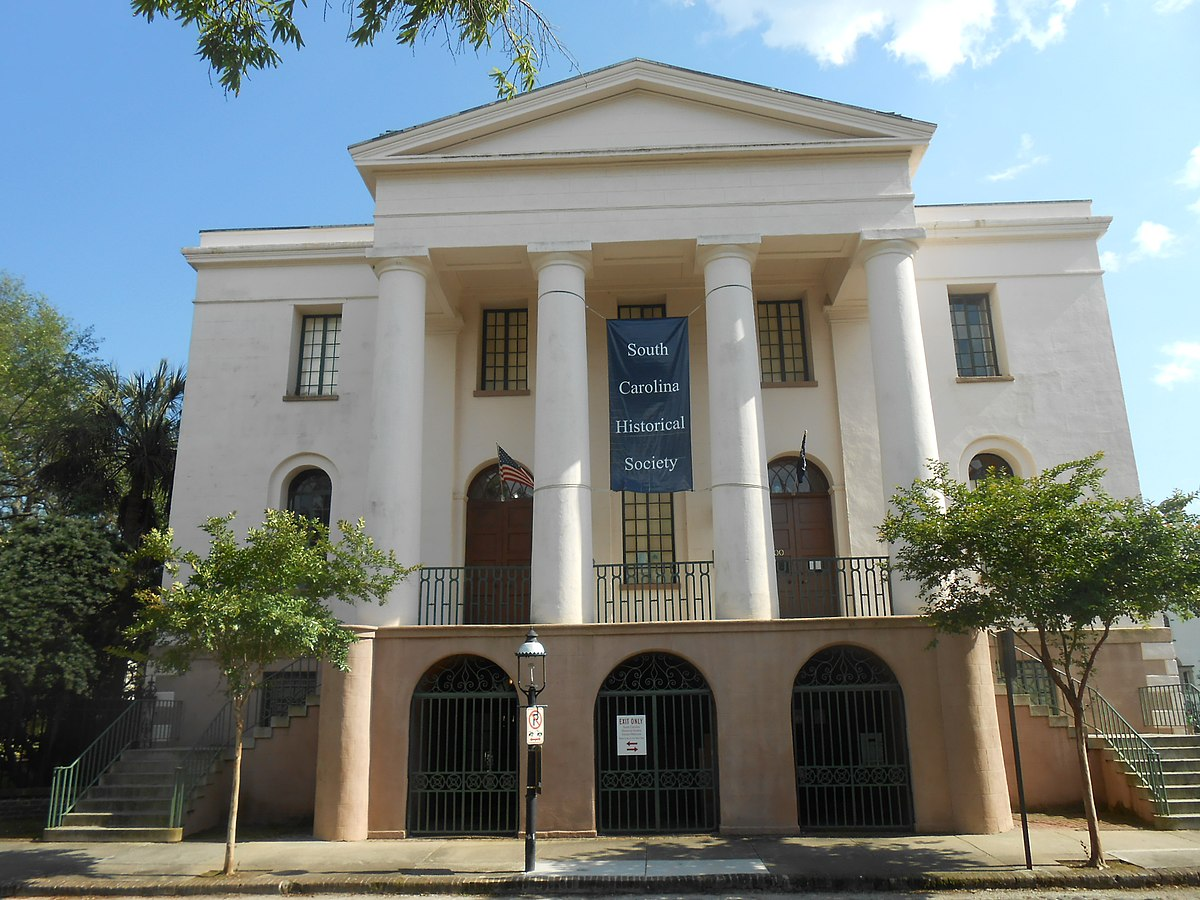

/wiki/South_Carolina_Historical_Society


In [24]:
# old version
random.seed(int(datetime.datetime.now().strftime('%f')))  

links=get_links(webpage)                      # Extracts and creates a list of links from Fremd's webpage
for i in range(20):                                                     # Loop to run 20 times
    new_article = links_from_crawl[i]  # Chooses random link from the list of links
    return_image(new_article,100)                                       # Call function created above, displays first image from link
    print(new_article)                                                  # Prints the random link
    links = get_links(new_article)                                      # Extracts and creates a list of links from the new webpage
    #time.sleep(1)                                                       # 1-second break before another loop

My version is not better from what I can see but it does work properly for the reddit wiki.

In [29]:
def final_get_image_url(article_url):
    html_page = urlopen("http://en.wikipedia.org"+article_url)                    # Opens whatever page we are requesting
    bs_obj = BeautifulSoup(html_page, 'html.parser')                              # Saves the html in a Beautiful Soup object
    try:
        image_url = 'http:' + bs_obj.find("td",{"class":"infobox-image"}).find('a').find('img').attrs['src']
    except AttributeError:
        try:
            image_url = get_image_url(article_url)
        except:
            image_url = False                                                         # If no URL is available, store 'False' instead
    return image_url                                                              # Return image's URL

In [30]:
# Is og_image the main picture?
def final_return_image(wiki_url,image_width):                         # Create function that accepts a Wiki topic and width desired
    
    if final_get_image_url(wiki_url) != False:                        # If there is an available URL        
        headers = {'User-Agent': 'Mozilla/5.0'}                     # Add a user-agent to our request
        # Does a user-agent tell that it is requesting the mozilla firefox site. If it is, is this how my phone gets a desktop site.
        img = final_get_image_url(wiki_url)
        request = requests.get(img, headers = headers)              # Request the image
        if request.status_code == 200:                              # If the request resolves "Ok"
            url_to_file = request.content                           # Extract image data from URL
            extension = img.split('.')[-1]                          # Extract image's name
            name = "output/output_image." + extension               # Create new name for image file
            with open(name, 'wb') as image:                         # Create a new file to write information to
                image.write(url_to_file)                            # Write the images data to the file
            display(Image(filename=name,width=image_width))         # Open image in notebook
        else:                                                   # Otherwise, give the status code
            print("Error, Status Code:", request.status_code)

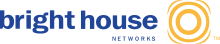

/wiki/Bright_House_Networks


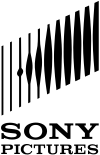

/wiki/Sony_Pictures
/wiki/Tony_Vinciquerra


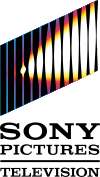

/wiki/Sony_Pictures_Television


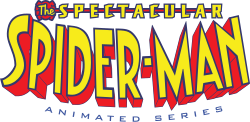

/wiki/The_Spectacular_Spider-Man_(TV_series)
/wiki/Action_(genre)
/wiki/Epitasis


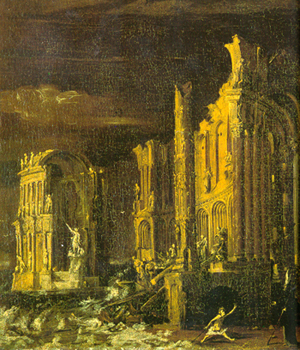

/wiki/Fictional_city


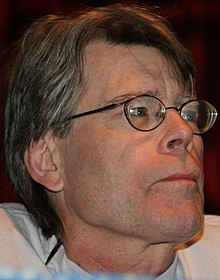

/wiki/Stephen_King


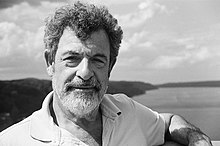

/wiki/Dolores_Claiborne_(opera)


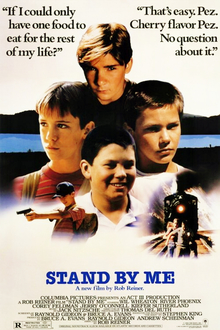

/wiki/Stand_by_Me_(film)
/wiki/Andrew_Scheinman


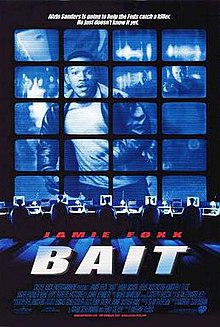

/wiki/Bait_(2000_film)


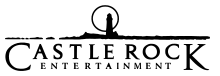

/wiki/Castle_Rock_Entertainment


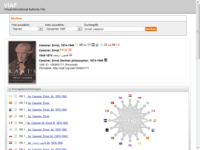

/wiki/VIAF_(identifier)


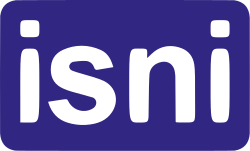

/wiki/International_Standard_Name_Identifier


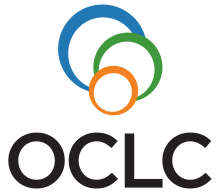

/wiki/Online_Computer_Library_Center
/wiki/Society_of_American_Archivists


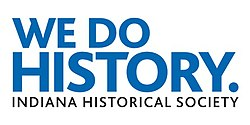

/wiki/Indiana_Historical_Society


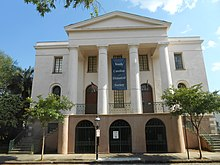

/wiki/South_Carolina_Historical_Society


In [31]:
# final version                   # Extracts and creates a list of links from Fremd's webpage
for i in range(20):                                                     # Loop to run 20 times
    new_article = links_from_crawl[i]  # Chooses random link from the list of links
    final_return_image(new_article,100)                                       # Call function created above, displays first image from link
    print(new_article)                                                  # Prints the random link
    links = get_links(new_article)                                      # Extracts and creates a list of links from the new webpage
    #time.sleep(1)                                                       # 1-second break before another loop

### <u>Answer the Following Wrap-up Questions:</u>  

**<u>Question 6:</u>**  What is web scraping? 

*Hint: Read https://en.wikipedia.org/wiki/Web_scraping*

**<u>Your Answer:</u>** Web scraping is data scraping used for extracting data from websites.

**<u>Question 7:</u>**  What is web crawling? 

*Hint: Read https://en.wikipedia.org/wiki/Web_crawler*

**<u>Your Answer:</u>** A Web crawler is an Internet bot that systematically browses the World Wide Web and that is typically operated by search engines for the purpose of Web indexing

**<u>Question 8:</u>** What is the difference between web scraping and web crawling?  

**<u>Your Answer:</u>** Web scraping looks for data on a page while a web crawler crawls across pages looking for links and stuff.
